In [1]:
# Importemos todo lo que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd
%matplotlib inline

from bs4 import BeautifulSoup
 
def read_excel_xml(path):
    file = open(path, encoding='ISO-8859-1').read()
    soup = BeautifulSoup(file,'xml')
    workbook = []
    for sheet in soup.findAll('Worksheet'): 
        sheet_as_list = []
        for row in sheet.findAll('Row'):
            row_as_list = []
            for cell in row.findAll('Cell'):
                row_as_list.append(cell.Data.text)
            sheet_as_list.append(row_as_list)
        workbook.append(sheet_as_list)
    return workbook

from datetime import datetime

In [2]:
# Leer el archivo y obtener el primer elemento (toda la info)
lista = read_excel_xml('acciones20150101-20180912.xls')
lista = lista[0]

In [3]:
# Obtener nombres de las acciones
nombres = [lista[i][0] for i in range(len(lista))]
nombres = set(nombres)
nombres.remove(u'Especie')
nombres = list(nombres)

In [61]:
# Crear el DataFrame a partir de los datos que obtuvimos, usando uno de los tickers
# como referencia y después ir agregando fechas a partir de eso.

df = pd.DataFrame(lista[1:], columns=lista[0])
finaldf = df[df[u'Especie'] == u'AGRO'][[u'Fecha']]
finaldf.columns = [u'Fecha']
finaldf = finaldf.set_index(u'Fecha')
for i in nombres:
    tempdf = df[df[u'Especie'] == i][[u'Fecha', u'Cierre del día']]
    tempdf.columns = [u'Fecha', i]
    finaldf = finaldf.join(tempdf.set_index(u'Fecha'),how='outer')

# Fijar la colección de fechas como índice
idx = df[df[u'Especie'] == u'GGAL'][[u'Fecha']].set_index(u'Fecha')

# Si queremos guardar el DF generado en un csv, usar comando de abajo
# finaldf.to_csv('acciones.csv')

In [62]:
# Hacer que el índice sean realmente fechas
finaldf.index = pd.to_datetime(finaldf.index,format='%d/%m/%Y')
# Hacer que los datos sean realmente numéricos
finaldf = finaldf.apply(pd.to_numeric)
# Reordenar el índice por fecha y luego completar los momentos en los que no se compró/vendió cada acción
finaldf.sort_index(inplace=True)
finaldf.fillna(method='ffill',inplace=True)

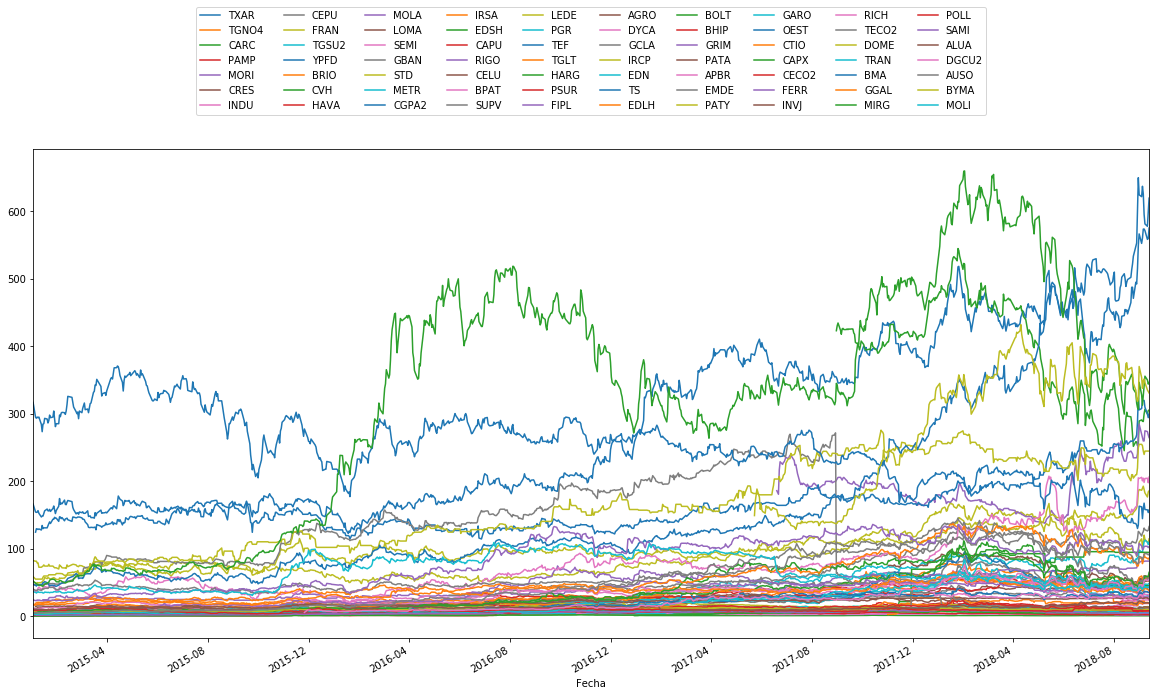

In [63]:
# VALO tiene mal los precios, vamos a tener que seguir sin esa acción
finaldf.drop('VALO', axis=1, inplace=True)
finaldf.plot(figsize=(20,10))
plt.legend(ncol=10, loc='upper center', bbox_to_anchor=(0.5, 1.3))


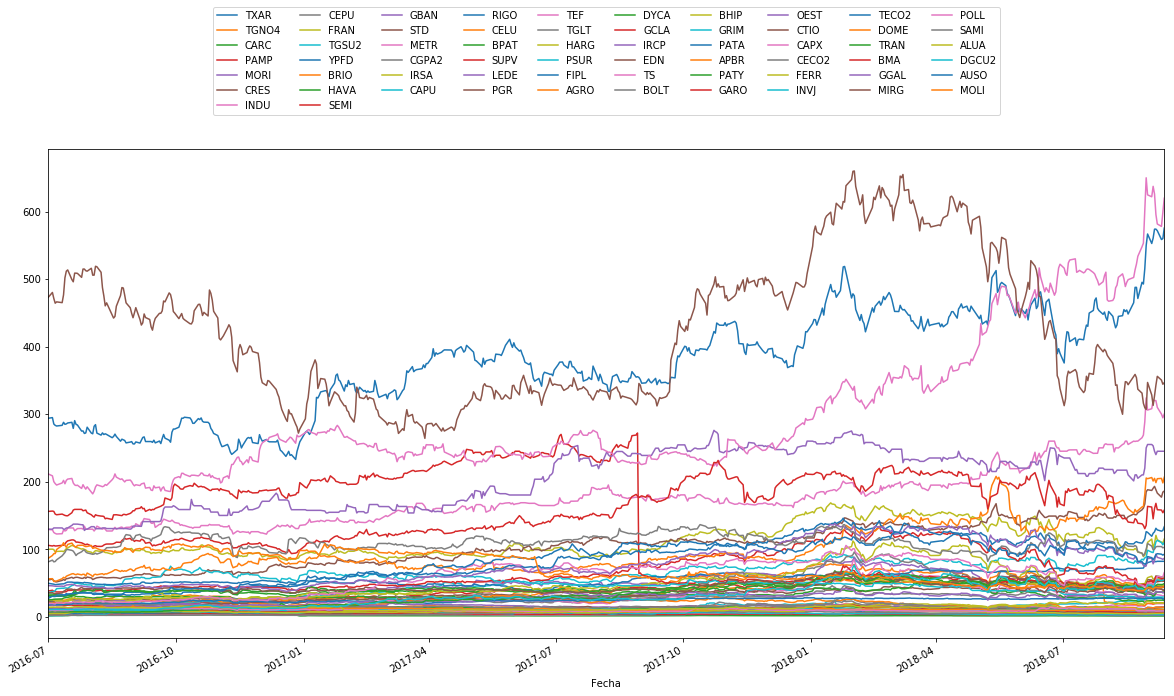

In [64]:
# Vamos a tener datos más uniformes, usemos sólo desde el segundo semestre de 2016
using = []
for ticker in finaldf.columns:
    if finaldf[ticker].first_valid_index() <= datetime(2016,7,1):
        using.append(ticker)
finaldf = finaldf.loc[datetime(2016,7,1):, using]
finaldf.plot(figsize=(20,10))
plt.legend(ncol=10, loc='upper center', bbox_to_anchor=(0.5, 1.3))


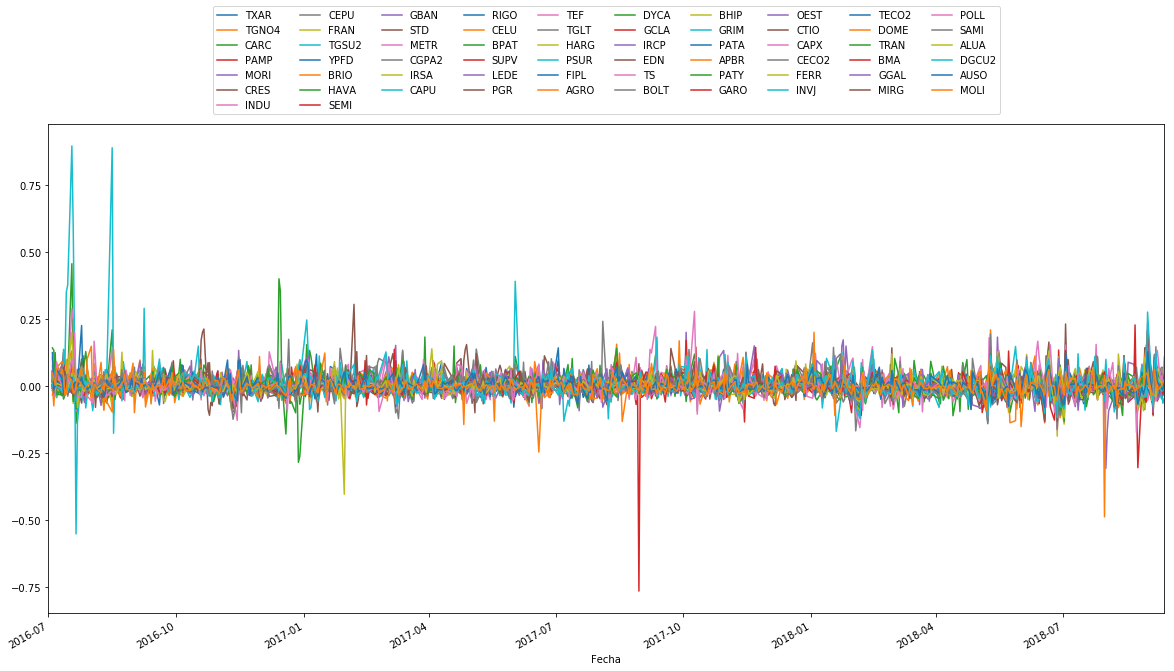

In [66]:
# Los datos no son muy comparables, vamos a usar incrementos porcentuales
finaldf.pct_change().plot(figsize=(20,10))
plt.legend(ncol=10, loc='upper center', bbox_to_anchor=(0.5, 1.25))


In [ ]:
# Datos del Merval obtenidos de Estadísticas BCRA
from ast import literal_eval
f = open('merval.dat')
mainlist = [list(literal_eval(line)) for line in f]
merv = pd.DataFrame(mainlist[0])
merv.index = pd.to_datetime(merv.d)
merv = merv['v']
# Unir el índice Merval con la data de acciones.
# finaldf['IMV'] = merv